In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

  Activating environment at `~/.julia/dev/ReactiveMPPaperExperiments/Project.toml`
┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have Random in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading Random into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [14]:
using CairoMakie # Plots related stuff
using ReactiveMP, Rocket, GraphPPL, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP: update! # naming conflicts 

#### Linear Multivariate Gaussian State-space Model

In this demo, the goal is to perform both Kalman filtering and smoothing algorithms for a Linear Multivariate Gaussian state-space model (LGSSM).

We wil use the following model:

$$
\begin{equation}
  \begin{aligned}
    p(\mathbf{x}_k|\mathbf{x}_{k - 1}) & = \, \mathcal{N}(\mathbf{x}_k|\mathbf{A}\mathbf{x}_{k - 1}, \mathcal{P}) \\
    p(\mathbf{y}_k|\mathbf{x}_k) & = \, \mathcal{N}(\mathbf{y}_k|\mathbf{B}\mathbf{x}_{k}, \mathcal{Q}) \\
  \end{aligned}
\end{equation}
$$

In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="../figures/ssm_model.png" width="45%">

Usually this type of model is used for a linear differential equations where the measured quantities were linear functions of the state. For example this can be the dynamics of the car or noisy pendulum model [Bayesian Filtering and Smoothing, Särkkä, Simo, p.~44].

### Data

For testing purposes we can use synthetically generated data where underlying data generation process matches our model specification.

Lets first see how our synthetic data look like. We plot an individual line for each dimension in our dataset. To make it uncluttered we generate 2-dimensional observations with rotation matrix as a transition matrix with θ parameter which represents rotation angle

In [102]:
test_params = let 
    seed = 42
    n    = 50
    θ    = π / 20

    A = rotation_matrix(θ)
    B = diagonal_matrix([ 1.3, 0.7 ])
    P = diagonal_matrix([ 1.0, 1.0 ])
    Q = diagonal_matrix([ 1.0, 1.0 ]);

    @strdict seed n θ A B P Q
end;

You may try to change data generation process parameters to immediatelly see how it affects data. We plot lines for real states $x_i$, and we plot scatter dots for noisy observations $y_i$.

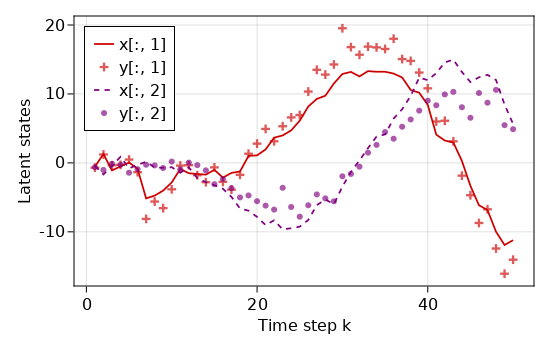

In [54]:
let 
    x, y  = generate_data(LGSSMModel(), test_params)
    range = 1:length(x)
    
    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")
    
    lines!(ax, range, x |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]", )
    scatter!(ax, range, y |> edim(1), color = (:red3, 0.65), markersize = 12, marker = :cross, label = "y[:, 1]")

    lines!(ax, range, x |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y |> edim(2), color = (:purple, 0.65), markersize = 8, marker = :circle, label = "y[:, 2]")
    
    axislegend(ax, position = :lt)
    
    @saveplot fig "lgssm_smoothing_data"
end

### Model and inference specification 

GraphPPL.jl offers a model specification syntax that resembles closely to the mathematical equations defined above. In this particular implementation we use `MvGaussianMeanCovariance` node for $\mathcal{N}(\mu, \Sigma)$ distribution. ReactiveMP.jl inference backend also supports `MvGaussianMeanPrecision` and `MvGaussianWeightedMeanPrecision` parametrisations for factor nodes. `datavar` placeholders are used to indicate variables that take specific values at a later date. For example, the way we feed observations into the model is by iteratively assigning each of the observations in our dataset to the data variables `y`.

#### Model specification for full graph and Smoothing algorithm

In [58]:
@model function linear_gaussian_ssm_full_graph(n, A, B, P, Q)     
    # We create a vector of random variables with length n
    x = randomvar(n) 

    # Create a vector of observations with length n
    y = datavar(Vector{Float64}, n) 

    # We create a `constvar` references for constants in our model
    # to hint inference engine and to make it a little bit more efficient
    cA = constvar(A)
    cB = constvar(B)
    cP = constvar(P)
    cQ = constvar(Q)

    d = first(size(A))
    pm = zeros(d)
    pc = Matrix(Diagonal(100.0 * ones(d)))

    # Set a prior distribution for x[1]
    x[1] ~ MvGaussianMeanCovariance(pm, pc) 
    y[1] ~ MvGaussianMeanCovariance(cB * x[1], cQ)

    for t in 2:n
        x[t] ~ MvGaussianMeanCovariance(cA * x[t - 1], cP)
        y[t] ~ MvGaussianMeanCovariance(cB * x[t], cQ)    
    end

    return x, y
end

linear_gaussian_ssm_full_graph (generic function with 1 method)

#### Inference for full graph

Next we need to define our inference procedure. FFG that represents our model has no loops hence we may perform exact Bayesian inference with sum-product algorithm. 

To obtain posterior marginal distributions of our latent state variables we simply use  `subscribe!` function together with `getmarginal` observable. To start inference we pass our observations with `update!` function. Here is a general template for inference function:

In [63]:
function inference_full_graph(observations, params)
    @unpack A, B, P, Q = params
    
    # We create a full graph based on how many observations
    # we have in our dataset
    n = length(observations) 

    # We call a `linear_gaussian_ssm_full_graph` function 
    # from our model specification above
    model, (x, y) = linear_gaussian_ssm_full_graph(
        n, A, B, P, Q, options = (limit_stack_depth = 500, )
    )

    # Rocket.jl provides some handy default actors
    # `buffer` actor simply copies all received updates 
    # into an internal buffer with length n
    xbuffer = buffer(Marginal, n)
    bfe     = ScoreActor(Float64)

    # For a collection of random variables we can use 
    # `getmarginals()` function which returns a stream of vectors
    xsubscription = subscribe!(getmarginals(x), xbuffer)
    fsubscription = subscribe!(score(Float64, BetheFreeEnergy(), model), bfe)

    update!(y, observations)

    # Usually we need to unsubscribe every time we're done with our model
    unsubscribe!(xsubscription)

    return map(getvalues, (xbuffer, bfe))
end

inference_full_graph (generic function with 2 methods)

In [103]:
smoothing_params = let 
    seed = 42
    n    = 50
    θ    = π / 20

    A = rotation_matrix(θ)
    B = diagonal_matrix([ 1.3, 0.7 ])
    P = diagonal_matrix([ 1.0, 1.0 ])
    Q = diagonal_matrix([ 1.0, 1.0 ]);

    @strdict seed n θ A B P Q
end;

In [104]:
x_smoothing, y_smoothing = generate_data(LGSSMModel(), smoothing_params)
x_smoothing_estimated, bfe_smoothing = inference_full_graph(y_smoothing, smoothing_params);

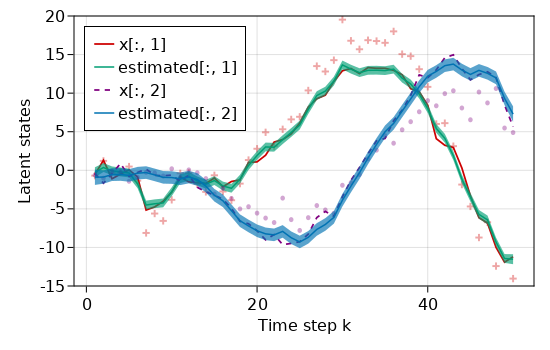

In [105]:
let
    ylimit = (-15, 20)
    c = Makie.wong_colors() 

    x_inferred_means = mean.(x_smoothing_estimated)
    x_inferred_stds  = diag.(std.(x_smoothing_estimated))
    range = 1:length(x_inferred_means)

    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    ylims!(ax, ylimit)

    # Real dim1
    lines!(ax, range, x_smoothing |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]",)
    scatter!(ax, range, y_smoothing |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_smoothing |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_smoothing |> edim(2), color = (:purple, 0.35),markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt)

    @saveplot fig "lgssm_smoothing_inference"
end

From inference results we can see that our model predicted latent states correctly and with high precision.

#### Model specification for single time step and Kalman filter algorithm

We may perform forward-only message-passing scheme which resembles Kalman filter for the same model. To do that it is enough to build a single time step of the model and to redirect posterior marginal updates from the next step to the priors of the previous time step. First, lets define a single time step of the model.

In [70]:
@model function linear_gaussian_ssm_single_time_segment(A, B, P, Q)
    cA = constvar(A)
    cB = constvar(B)
    cP = constvar(P)
    cQ = constvar(Q)

    # We create a `datavar` placeholders for priors for the previous time step
    # We will later iteratively change our priors based on posterior marginals
    # on each time step
    x_min_t_mean = datavar(Vector{Float64})
    x_min_t_cov  = datavar(Matrix{Float64})

    x_min_t ~ MvGaussianMeanCovariance(x_min_t_mean, x_min_t_cov)
    x_t     ~ MvGaussianMeanCovariance(cA * x_min_t, cP)

    y_t = datavar(Vector{Float64})
    y_t ~ MvGaussianMeanCovariance(cB * x_t, cQ)

    return x_min_t_mean, x_min_t_cov, x_t, y_t
end

linear_gaussian_ssm_single_time_segment (generic function with 1 method)

#### Inference for single time step

In [71]:
function inference_single_time_segment(observations, params)
    @unpack A, B, P, Q = params
    n = length(observations) 

    model, (x_min_t_mean, x_min_t_cov, x_t, y_t) =
        linear_gaussian_ssm_single_time_segment(A, B, P, Q)

    # We want to keep a full history of posterior marginal updates 
    # for all time steps
    xbuffer = keep(Marginal)
    bfe     = ScoreActor(Float64)

    # Here we redirect our posterior marginal distribution from the current
    # time step to the priors and proceed with the next time step
    redirect_to_prior = subscribe!(getmarginal(x_t), (x_t_posterior) -> begin
        update!(x_min_t_mean, mean(x_t_posterior))
        update!(x_min_t_cov, cov(x_t_posterior))    
    end)

    xsubscription = subscribe!(getmarginal(x_t), xbuffer)
    fsubscription = subscribe!(score(Float64, BetheFreeEnergy(), model), bfe)

    d = first(size(A))
    pm = zeros(d)
    pc = Matrix(Diagonal(100.0 * ones(d)))

    # Priors for the very first observation
    update!(x_min_t_mean, pm)
    update!(x_min_t_cov, pc)

    for observation in observations
        update!(y_t, observation)
        release!(bfe)
    end

    unsubscribe!(xsubscription)
    unsubscribe!(redirect_to_prior)

    return map(getvalues, (xbuffer, bfe))
end

inference_single_time_segment (generic function with 1 method)

In [106]:
filtering_params = let 
    seed = 42
    n    = 50
    θ    = π / 20

    A = rotation_matrix(θ)
    B = diagonal_matrix([ 1.3, 0.7 ])
    P = diagonal_matrix([ 1.0, 1.0 ])
    Q = diagonal_matrix([ 1.0, 1.0 ]);
    
    data = 

    @strdict seed n θ A B P Q
end;

In [107]:
x_filtering, y_filtering = generate_data(LGSSMModel(), filtering_params)
x_filtering_estimated, bfe_filtering = inference_single_time_segment(y_filtering, filtering_params);

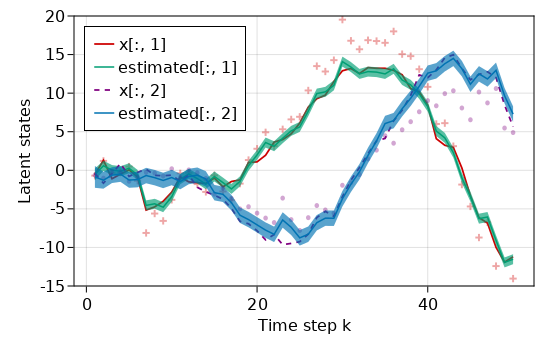

In [108]:
let
    ylimit = (-15, 20)
    c = Makie.wong_colors() 

    x_inferred_means = mean.(x_filtering_estimated)
    x_inferred_stds  = diag.(std.(x_filtering_estimated))
    range = 1:length(x_inferred_means)

    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    ylims!(ax, ylimit)

    # Real dim1
    lines!(ax, range, x_filtering |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]",)
    scatter!(ax, range, y_filtering |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_filtering |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_filtering |> edim(2), color = (:purple, 0.35),markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt)

    @saveplot fig "lgssm_filtering_inference"
end

Compared to the previous demo (smoothing), the state estimation algorithm in this demo only passes messages forward in time. Therefore, the state estimates are less accurate than the smoothing result of the previous demo.

### Benchmark

In this section we will benchmark inference performance with the help of BenchmarkTools package. `ReactiveMP.jl` has been designed to be efficient and scalable as much as possible. To show `ReactiveMP.jl` performance capabilities we run a series of benchmark tests for linear gaussian state space model with different number of observations and different seeds and θ parameters. We show that execution time scales linearly on number of observations. 

In [83]:
function run_benchmark(inference_fn::Function, params)
    @unpack n, d, seed = params

    rng = MersenneTwister(seed)

    A = random_posdef_matrix(rng, d)
    B = random_posdef_matrix(rng, d)
    P = Matrix(Diagonal(ones(d)))
    Q = Matrix(Diagonal(ones(d)))
    
    data_params = @strdict n seed A B P Q

    x, y = generate_data(LGSSMModel(), data_params)

    x_estimated, bfe = inference_fn(y, A, B, P, Q);
    benchmark        = @benchmark $inference_fn($y, $A, $B, $P, $Q)

    output = @strdict n d seed x_estimated bfe benchmark

    return output
end

run_benchmark (generic function with 1 method)

We want to perform benchmarking for different sets of parameters. In principal, timings should not depend on seed and θ parameters, but only on n.

In [86]:
# Here we create a list of parameters we want to run our benchmarks with
benchmark_allparams = dict_list(Dict(
    "n"    => [ 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 5000, 10000, 100000 ],
    "d"    => [ 2, 3, 10 ],	
    "seed" => [ 42 ]
));

In [87]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
smoothing_benchmarks = map(benchmark_allparams) do params
    path = datadir("benchmark", "lgssm", "smoothing")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(inference_full_graph, p)
    end
    return result
end;

In [88]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create aew benchmarks 
# but will reload it from data folder
filtering_benchmarks = map(benchmark_allparams) do params
    path = datadir("benchmark", "lgssm", "filtering")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(inference_single_time_segment, p)
    end
    return result
end;

Here we extract benchmarking results in a `DataFrame` table for seed = $(target_seed) and d = $(target_d)

In [90]:
target_seed = 42
target_d = 3

3

In [109]:
let
    path_filtering = datadir("benchmark", "lgssm", "filtering")
    path_smoothing = datadir("benchmark", "lgssm", "smoothing")

    white_list   = [ "n", "seed", "d" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%")
    ]

    df_filtering = collect_results(path_filtering, white_list = white_list, special_list = special_list, verbose = false)
    df_smoothing = collect_results(path_smoothing, white_list = white_list, special_list = special_list, verbose = false)

    query_filtering = @from row in df_filtering begin
        @where row.seed == target_seed && row.d == target_d
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime }
    end

    query_smoothing = @from row in df_smoothing begin
        @where row.seed == target_seed && row.d == target_d
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime }
    end

    res_filtering = DataFrame(query_filtering)
    res_smoothing = DataFrame(query_smoothing)
    
    df = rightjoin(res_filtering, res_smoothing, on = :n, makeunique = true)
    df = rename(df,
        :min => Symbol("Time (filtering)"),
        :min_1 => Symbol("Time (smoothing)"),
        :gctime => Symbol("GC (filtering)"),
        :gctime_1 => Symbol("GC (smoothing)")
    )
end

┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/lgssm/filtering for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/result_collection.jl:88
┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/lgssm/smoothing for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/Kwvgi/src/result_collection.jl:88


,n,Time (filtering),GC (filtering),Time (smoothing),GC (smoothing)
,Int64?,String?,String?,String?,String?
1,50,3.47ms,0.0%,7.35ms,0.0%
2,100,6.09ms,0.0%,14.86ms,0.0%
3,250,16.31ms,0.0%,41.66ms,0.0%
4,500,33.23ms,0.0%,86.54ms,0.0%
5,750,47.88ms,0.0%,137.7ms,0.0%
6,1000,66.85ms,0.0%,181.06ms,0.0%
7,1500,101.19ms,0.0%,312.11ms,15.21%
8,2000,139.53ms,0.0%,413.23ms,17.13%
9,2500,173.48ms,0.0%,546.69ms,17.97%


Lets also plot benchmark timings for both smoothing and filtering algorithms against number of observation. Notice that we use a log scale axis to have a linear-like plot.

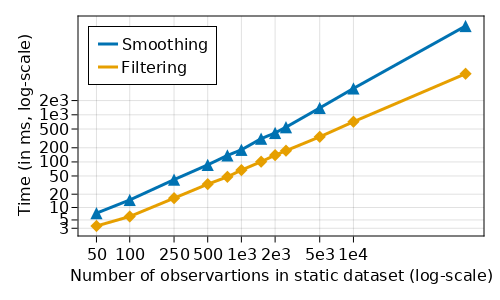

In [101]:
let
    s_filtered = filter(smoothing_benchmarks) do b
        return b["d"] === target_d && b["seed"] === target_seed
    end

    f_filtered = filter(filtering_benchmarks) do b
        return b["d"] === target_d && b["seed"] === target_seed
    end

    @assert length(s_filtered) !== 0 "Empty benchmark set"
    @assert length(f_filtered) !== 0 "Empty benchmark set"

    s_range      = map(f -> f["n"], s_filtered)
    s_benchmarks = map(f -> f["benchmark"], s_filtered)
    s_timings    = map(t -> t.time, minimum.(s_benchmarks)) ./ 1_000_000
    s_memories   = map(t -> t.memory, minimum.(s_benchmarks)) ./ 1024

    f_range      = map(f -> f["n"], f_filtered)
    f_benchmarks = map(f -> f["benchmark"], f_filtered)
    f_timings    = map(t -> t.time, minimum.(f_benchmarks)) ./ 1_000_000
    f_memories   = map(t -> t.memory, minimum.(f_benchmarks)) ./ 1024

    fig = Figure(resolution = (500, 300))

    ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of observartions in static dataset (log-scale)"
    ax.xlabelsize = 16
    ax.ylabel = "Time (in ms, log-scale)"
    ax.ylabelsize = 16
    ax.yscale = Makie.pseudolog10
    ax.xscale = Makie.pseudolog10

    ax.yticks = (
        [ 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000 ], 
        [ "3", "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3" ]
    )

    ax.xticks = (
        [ 50, 100, 250, 500, 1000, 2000, 5000, 10000 ], 
        [ "50", "100", "250", "500", "1e3", "2e3", "5e3", "1e4" ]
    )

    lines!(ax, s_range, s_timings, label = "Smoothing", linewidth = 3)
    scatter!(ax, s_range, s_timings, marker = :utriangle, markersize = 16)

    lines!(ax, f_range, f_timings, label = "Filtering", linewidth = 3)
    scatter!(ax, f_range, f_timings, marker = :diamond, markersize = 16)

    axislegend(ax, position = :lt, labelsize = 16)

    @saveplot fig "lgssm_benchmark"
end